## 1次元の畳み込みニューラルネットワークスクラッチ

>このSprintでは1次元の 畳み込み層 を作成し、畳み込みの基礎を理解することを目指します。  
>次のSprintでは2次元畳み込み層とプーリング層を作成することで、一般的に画像に対して利用されるCNNを完成させます。

### 1次元畳み込み層とは  
>CNNでは画像に対しての2次元畳み込み層が定番ですが、ここでは理解しやすくするためにまずは1次元畳み込み層を実装します。  
>1次元畳み込みは実用上は自然言語や波形データなどの 系列データ で使われることが多いです。
>
>畳み込みは任意の次元に対して考えることができ、立体データに対しての3次元畳み込みまではフレームワークで一般的に用意されています。



### データセットの用意  
>検証には引き続きMNISTデータセットを使用します。1次元畳み込みでは全結合のニューラルネットワークと同様に平滑化されたものを入力します。

## MNISTデータセット  

In [1]:
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
# 平準化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [4]:
# 前処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

In [5]:
#from sklearn.preprocessing import OneHotEncoder
#enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
#y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
#y_test_one_hot = enc.transform(y_test[:, np.newaxis])
#print(y_train.shape) # (60000,)
#print(y_train_one_hot.shape) # (60000, 10)
#print(y_train_one_hot.dtype) # float64

In [6]:
#from sklearn.model_selection import train_test_split

In [7]:
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
#print(X_train.shape) # (48000, 784)
#print(X_val.shape) # (12000, 784)
#print(y_train.shape)
#print(y_val.shape)

## 【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成  
>チャンネル数を1に限定した1次元畳み込み層のクラスSimpleConv1dを作成してください。  
>基本構造は前のSprintで作成した全結合層のFCクラスと同じになります。  
>なお、重みの初期化に関するクラスは必要に応じて作り変えてください。  
>Xavierの初期値などを使う点は全結合層と同様です。
>
>ここでは **パディング** は考えず、**ストライド** も1に固定します。  
>また、複数のデータを同時に処理することも考えなくて良く、バッチサイズは1のみに対応してください。  >
>この部分の拡張はアドバンス課題とします。
>
>フォワードプロパゲーションの数式は以下のようになります。
>
>$
a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b
$
>
>
>ai : 出力される配列のi番目の値
>
>F : フィルタのサイズ
>
>$x_{(i+s)}$ : 入力の配列の(i+s)番目の値
>
>ws : 重みの配列のs番目の値
>
>b : バイアス項
>
>全てスカラーです。

>次に更新式です。ここがAdaGradなどに置き換えられる点は全結合層と同様です。  
>
>$
w_s^{\prime} = w_s - \alpha \frac{\partial L}{\partial w_s} \\
b^{\prime} = b - \alpha \frac{\partial L}{\partial b}
$
>
>α  : 学習率
>
>$\frac{\partial L}{\partial w_s}$ : ws に関する損失 L の勾配
>
>$\frac{\partial L}{\partial b}$ : b に関する損失 L の勾配
>
>勾配 $\frac{\partial L}{\partial b}$ や $\frac{\partial L}{\partial b}$ を求めるためのバックプロパゲーションの数式が以下です。
>
>$
\frac{\partial L}{\partial w_s} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}x_{(i+s)}\\
\frac{\partial L}{\partial b} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}
$
>
>$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi番目の値
>
>$N_{out}$ : 出力のサイズ
>
>前の層に流す誤差の数式は以下です。
>
>$
\frac{\partial L}{\partial x_j} = \sum_{s=0}^{F-1} \frac{\partial L}{\partial a_{(j-s)}}w_s
$
>
>$\frac{\partial L}{\partial x_j}$  : 前の層に流す誤差の配列のj番目の値
>
>ただし、 $j-s<0$ または $j-s>N_{out}-1$ のとき $\frac{\partial L}{\partial a_{(j-s)}} =0$ です。
>
>全結合層との大きな違いは、重みが複数の特徴量に対して共有されていることです。この場合は共有されている分の誤差を全て足すことで勾配を求めます。計算グラフ上での分岐はバックプロパゲーションの際に誤差の足し算をすれば良いことになります。

In [8]:
class SimpleConv1d():
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, F, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.F = F
        self.W = initializer.W(self.F,)
        self.B = initializer.B()
    
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.X = X
        
        self.n_input=len(self.X)#.shape[1]
        #F=3
        stride=1
        padding=0
        self.n_output = self.output_size(self.n_input, self.F, P=padding, S=stride)
        
        print("X.shape: {}".format(X.shape))
        
        A = np.zeros(len(X)-(F-1))#self.n_input
        for i in range(len(X)-(F-1)):#self.n_input
            A[i] = X[i:i+self.F].T@self.W+self.B
            
        self.A = A
            
        print("self.A.shape: {}".format(self.A.shape))
        
        return self.A
    
    
    def backward(self,):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # 想定されるラベル
        y_conv1d = np.array([45, 70])
        
        dA = y_conv1d - self.A
        
        # 更新
        self, dZ = self.optimizer.update(self, dA, self.X)
        
        return dZ
    
    def output_size(self, n_input, F, P=0, S=1):
        """
        出力数数える
        """
        n_output = int((n_input + 2*P - F)/S + 1)

        return n_output
                 

#### 初期化方法のクラス化

In [9]:
class SimpleInitializer():
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_filter):
        """
        重みの初期化
        Parameters
        ----------
        n_filter : int
          フィルタのサイズ

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_filter, )
        
        return W
    
    
    def B(self, ):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        size=1
        B = self.sigma * np.random.randn(size,)
        
        return B

In [10]:
class XavierInitializer():
    """
    ザビエル
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
        訓練データ
    """
    def __init__(self, n_filter):#シグマではなくノード数を入れる　n_filter？
        sigma = 1/np.sqrt(n_filter)
        self.sigma = sigma
        
    def W(self, n_filter):
        W = self.sigma * np.random.randn(n_filter,)
        
        return W
    
    def B(self, ):
        
        size=1
        B = self.sigma * np.random.randn(size,)
        
        return B

In [11]:
class HeInitializer():
    """
    フー
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
        訓練データ
    """
    def __init__(self, n_filter):#シグマではなくノード数を入れる　n_filter？
        sigma = np.sqrt(2/n_filter)
        self.sigma = sigma

    def W(self, n_filter):
        W = self.sigma * np.random.randn(n_filter, )
        
        return W
    
    def B(self, ):
        size=1
        B = self.sigma * np.random.randn(size, )
        
        return B

#### 更新式

In [12]:
class RenewalFormula():
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer, dA, X):#Z3, Y, 
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        # フィルタのサイズ
        F = len(layer.W)
        
        dW = np.zeros(F)
        for i in range(layer.n_output):
            dW += dA[i]*X[i:i+F]
            
        print()
        print("dW: {}".format(dW))
            
        dB = np.sum(dA)#, axis=0
        print("dB: {}".format(dB))
        print()
        
        dX = np.zeros(len(X))
        for j in range(len(dA)):
            #for s in range(len(layer.W)):#len(layer.W)-1
            #if not(j-s < 0) and not(j-s > len(dA)-1):
            dL_dA = dA[j]*layer.W
            dX[j:j+F] += dL_dA
            
        print("dX: \n{}".format(dX))
        print()
        
        layer.W = layer.W - self.lr*(dW)
        layer.B = layer.B - self.lr*(dB)
        
        return (layer, dX)
        

In [13]:
#class AdaGrad():
#    """
#    最適化手法AdaGrad
#    Parameters
#    ----------
#    X : 次の形のndarray, shape (n_samples, n_features)
#        訓練データ
#    """
#    def __init__(self, lr, n_nodes):
#        self.lr = lr
#        # RuntimeWarning: divide by zero encountered を避ける
#        self.H = np.zeros(n_nodes)+1e-10
#        
#    def update(self, layer, dA, Z):
#        #dL_dA3 = Z3 - Y
#        dB = np.sum(dA, axis=0)#バッチサイズ分の合計
#        dW = Z.T@dA
#        
#        dZ = dA@layer.W.T
#        
#        self.H = self.H + np.mean(dW, axis = 0)*np.mean(dW, axis = 0)
#        
#        layer.W = layer.W - self.lr*(1/np.sqrt(self.H))*np.mean(dW, axis = 0)
#        layer.B = layer.B - self.lr*(1/np.sqrt(self.H))*np.mean(dW, axis = 0)
#        
#        return (layer, dZ)

## 【問題2】1次元畳み込み後の出力サイズの計算  
>畳み込みを行うと特徴量の数が変化します。どのように変化するかは以下の数式から求められます。
>パディングやストライドも含めています。この計算を行う関数を作成してください。
>
>$
N_{out} =  \frac{N_{in}+2P-F}{S} + 1\\
$
>
>$N_{out}$  : 出力のサイズ（特徴量の数）
>
>$N_{in}$ : 入力のサイズ（特徴量の数）
>
>P : ある方向へのパディングの数
>
>F : フィルタのサイズ
>
>S : ストライドのサイズ

クラス内にoutput_sizeメソッドを作成。  

In [14]:
n_nodes1=4
n_nodes2=2
initializer=SimpleInitializer(0.01)
optimizer=RenewalFormula(1)
F=3
# インスタンス化
CNN_size = SimpleConv1d(n_nodes1, n_nodes2, F, initializer, optimizer)

print("W.shape: {}".format(CNN_size.W.shape))
print("B.shape: {}".format(CNN_size.B.shape))

W.shape: (3,)
B.shape: (1,)


In [15]:
CNN_size.output_size(n_input=4, F=3, P=0, S=1)

2

forward関数内にて呼び出してself.n_outputとして値を保管できるように設計。

In [16]:
X = np.array([1, 2, 3, 4])
CNN_size.forward(X)

X.shape: (4,)
self.A.shape: (2,)


array([-0.04271782, -0.05690343])

In [17]:
CNN_size.n_output

2

## 【問題3】小さな配列での1次元畳み込み層の実験  
>次に示す小さな配列でフォワードプロパゲーションとバックプロパゲーションが正しく行えているか確認してください。

#### 動作検証用のデータセット

>入力x、重みw、バイアスbを次のようにします。

In [18]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])

>フォワードプロパゲーションをすると出力は次のようになります。  
>a = np.array([35, 50])

>次にバックプロパゲーションを考えます。誤差は次のようであったとします。  
>delta_a = np.array([10, 20])

>バックプロパゲーションをすると次のような値になります。
>
>delta_b = np.array([30])  
>delta_w = np.array([50, 80, 110])  
>delta_x = np.array([30, 110, 170, 140])  

In [19]:
# テスト用のコピー
class SimpleConv1dTest():
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, F, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.F = F
        #self.W = initializer.W(F,)
        #self.B = initializer.B()
        
        # テスト用
        self.W = np.array([3, 5, 7])
        self.B = np.array([1])
    
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.X = X
        
        self.n_input=len(self.X)#.shape[1]
        #F=3
        stride=1
        padding=0
        self.n_output = self.output_size(self.n_input, self.F, P=padding, S=stride)
        
        print("X.shape: {}".format(X.shape))
        
        A = np.zeros(len(X)-(F-1))#self.n_input
        for i in range(len(X)-(F-1)):#self.n_input
            A[i] = X[i:i+self.F].T@self.W+self.B
            
        self.A = A
            
        print("self.A.shape: {}".format(self.A.shape))
        
        return self.A
    
    
    def backward(self,):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # 想定されるラベル
        y_conv1d = np.array([45, 70])
        
        dA = y_conv1d - self.A
        
        # 更新
        self, dZ = self.optimizer.update(self, dA, self.X)
        
        return dZ
    
    def output_size(self, n_input, F, P=0, S=1):
        """
        出力数数える
        """
        n_output = int((n_input + 2*P - F)/S + 1)

        return n_output
                 

In [20]:
n_nodes1=4
n_nodes2=2
initializer=SimpleInitializer(0.01)
optimizer=RenewalFormula(1)
F=3
# インスタンス化
CNN_check = SimpleConv1dTest(n_nodes1, n_nodes2, F, initializer, optimizer)

print("W.shape: {}".format(CNN_check.W.shape))
print("B.shape: {}".format(CNN_check.B.shape))

W.shape: (3,)
B.shape: (1,)


In [21]:
CNN_check.forward(x)

X.shape: (4,)
self.A.shape: (2,)


array([35., 50.])

In [22]:
CNN_check.backward()


dW: [ 50.  80. 110.]
dB: 30.0

dX: 
[ 30. 110. 170. 140.]



array([ 30., 110., 170., 140.])

## 実装上の工夫  
>畳み込みを実装する場合は、まずはfor文を重ねていく形で構いません。  
>しかし、できるだけ計算は効率化させたいため、以下の式を一度に計算する方法を考えることにします。
>
>$
a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b
$
>
>バイアス項は単純な足し算のため、重みの部分を見ます。
>
>$
\sum_{s=0}^{F-1}x_{(i+s)}w_s
$
>
>これは、xの一部を取り出した配列とwの配列の内積です。  
>具体的な状況を考えると、以下のようなコードで計算できます。  
>この例では流れを分かりやすくするために、各要素同士でアダマール積を計算してから合計を計算しています。  
>これは結果的に内積と同様です。



In [23]:
#x = np.array([1, 2, 3, 4])
#w = np.array([3, 5, 7])
#a = np.empty((2, 3))
#indexes0 = np.array([0, 1, 2]).astype(np.int)
#indexes1 = np.array([1, 2, 3]).astype(np.int)
#a[0] = x[indexes0]*w # x[indexes0]は([1, 2, 3])である
#a[1] = x[indexes1]*w # x[indexes1]は([2, 3, 4])である
#a = a.sum(axis=1)

>ndarrayは配列を使ったインデックス指定ができることを利用した方法です。
>
>また、二次元配列を使えば一次元配列から二次元配列が取り出せます。

In [24]:
#x = np.array([1, 2, 3, 4])
#indexes = np.array([[0, 1, 2], [1, 2, 3]]).astype(np.int)
#print(x[indexes]) # ([[1, 2, 3], [2, 3, 4]])

>このこととブロードキャストなどをうまく組み合わせることで、一度にまとめて計算することも可能です。
>
>畳み込みの計算方法に正解はないので、自分なりに効率化していってください。
>
>《参考》
>
>以下のページのInteger array indexingの部分がこの方法についての記述です。
>
>Indexing — NumPy v1.17 Manual




#### 実施内容
更新用クラスRenewalFormula内のupdateメソッド内にて、Xをスライスで取り出すことで対応。

## 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成  
>チャンネル数を1に限定しない1次元畳み込み層のクラスConv1dを作成してください。
>
>例えば以下のようなx, w, bがあった場合は、

In [25]:
x_conv1d = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]) # （出力チャンネル数）

>出力は次のようになります。

In [26]:
a = np.array([[16, 22], [17, 23], [18, 24]]) 
# shape(3, 2)で、（出力チャンネル数、特徴量数）である。

>入力が2チャンネル、出力が3チャンネルの例です。  
>計算グラフを書いた上で、バックプロパゲーションも手計算で考えてみましょう。  
>計算グラフの中には和と積しか登場しないので、微分を新たに考える必要はありません。

#### 《補足》  
>
>チャンネル数を加える場合、配列をどういう順番にするかという問題があります。  
(バッチサイズ、チャンネル数、特徴量数)または(バッチサイズ、特徴量数、チャンネル数)が一般的で、ライブラリによって順番は異なっています。（切り替えて使用できるものもあります）
>
>今回のスクラッチでは自身の実装上どちらが効率的かを考えて選んでください。
>上記の例ではバッチサイズは考えておらず、(チャンネル数、特徴量数)です。

In [27]:
class Conv1d():
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, n_filter, n_channel, F, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.F = F
        # テスト用
        self.W = np.array([[[1, 1, 2], [2, 1, 1]], [[2, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1]]])
        #self.W = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
        self.B = np.array([1, 2, 3]) # （出力チャンネル数）
        
        #w(出力チャンネル数、入力チャンネル数、フィルタサイズ)
        #b（出力チャンネル数）
        #self.W = initializer.W(n_filter, n_channel, self.F)
        #self.B = initializer.B(n_filter)
        
        self.n_filter = n_filter
        self.n_channel = n_channel
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        #x(入力チャンネル数、特徴量数)
        self.X = X
        
        self.n_input=self.X.shape[1]#.shape[1]
        
        #F=3
        stride=1
        padding=0
        self.n_output = self.output_size(self.n_input, self.F, P=padding, S=stride)
        
        A = np.empty((self.n_filter,self.n_output))
        for f in range(self.n_filter):
            for a_o in range(self.n_output):
                A[f, a_o] = np.sum(X[:, a_o:a_o+self.F]*self.W[f])+self.B[f]
   
        self.A = A
        
        return self.A
    
    
    def backward(self,):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # 想定されるラベル
        y_conv1d = np.array([[30, 40], [50, 60], [70, 80]]) 
        #y_conv1d = np.array([45, 70])
        
        dA = y_conv1d - self.A
        
        # 更新
        self, dZ = self.optimizer.update(self, dA, self.X)
        
        return dZ
    
    def output_size(self, n_input, F, P=0, S=1):
        """
        出力数数える
        """
        n_output = int((n_input + 2*P - F)/S + 1)

        return n_output
                 

#### 初期化方法のクラス化

In [28]:
class SimpleInitializer_q4():
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_filter, n_channel, F):
        """
        重みの初期化
        Parameters
        ----------
        n_filter : int
          フィルタのサイズ

        Returns
        ----------
        W :
        """
        #【問題2】
        W = self.sigma * np.random.randn(n_filter, n_channel, F)
        
        return W
    
    
    def B(self, n_filter):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(n_filter, )
        
        return B

In [29]:
class XavierInitializer_q4():
    """
    ザビエル
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
        訓練データ
    """
    def __init__(self, n_filter):#シグマではなくノード数を入れる　n_filter？
        sigma = 1/np.sqrt(n_filter)
        self.sigma = sigma
        
    def W(self, n_filter, n_channel, F):
        W = self.sigma * np.random.randn(n_filter, n_channel, F)
        
        return W
    
    def B(self, ):
        B = self.sigma * np.random.randn(n_filter,)
        
        return B

In [30]:
class HeInitializer_q4():
    """
    フー
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
        訓練データ
    """
    def __init__(self, n_filter):#シグマではなくノード数を入れる　n_filter？
        sigma = np.sqrt(2/n_filter)
        self.sigma = sigma

    def W(self, n_filter, n_channel, F):
        W = self.sigma * np.random.randn(n_filter, n_channel, F)
        
        return W
    
    def B(self, ):
        B = self.sigma * np.random.randn(n_filter, )
        
        return B

#### 更新式

In [31]:
class RenewalFormula_q4():
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer, dA, X):#Z3, Y, 
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        dW_temp = []
        for f in range(layer.n_filter):
            dA_X = []
            for i in range(layer.n_output):
                dA_X.append(dA[f, i]*X[:, i:i+layer.F])    
            dW_temp.append(dA_X)
        
        dW_temp = np.array(dW_temp)
        
        dW = []
        for f in range(layer.n_filter):
            dW_c = []
            for c in range(layer.n_channel):
                dW_dW = np.zeros(layer.F)
                for i in range(layer.n_output):
                    dW_dW += dW_temp[f, i, c, :]
                dW_c.append(dW_dW)
            dW.append(dW_c)
        dW = np.array(dW)
        
        print("dW: \n{}".format(dW))
        print()
        
        dB = np.sum(dA, axis=1)#, axis=0
        print("dB: {}".format(dB))
        print()
        
        
        # X
        dX=np.zeros(X.shape)#layer.n_channel, layer.n_input
        for f in range(layer.n_filter):#チャネル
            for i in range(layer.n_output):#９、１１
                for c in range(layer.n_channel):#フィルタの選択
                    dX[c, i:i+layer.F] += dA[f, i]*layer.W[f, c]
                
        print("dX: \n{}".format(dX))
        print()
        
        layer.W = layer.W - self.lr*(dW)
        layer.B = layer.B - self.lr*(dB)
        
        return (layer, dX)
        

In [32]:
#class AdaGrad_q4():
#    """
#    最適化手法AdaGrad
#    Parameters
#    ----------
#    X : 次の形のndarray, shape (n_samples, n_features)
#    訓練データ
#    """
#    def __init__(self, lr, n_nodes):
#        self.lr = lr
#        # RuntimeWarning: divide by zero encountered を避ける
#        self.H = np.zeros(n_nodes)+1e-10
#        
#    def update(self, layer, dA, Z):
#        #dL_dA3 = Z3 - Y
#        dB = np.sum(dA, axis=0)#バッチサイズ分の合計
#        dW = Z.T@dA
#        
#        dZ = dA@layer.W.T
#        
#        self.H = self.H + np.mean(dW, axis = 0)*np.mean(dW, axis = 0)
#        
#        layer.W = layer.W - self.lr*(1/np.sqrt(self.H))*np.mean(dW, axis = 0)
#        layer.B = layer.B - self.lr*(1/np.sqrt(self.H))*np.mean(dW, axis = 0)
#        
#        return (layer, dZ)

インスタンス化

In [33]:
#x(入力チャンネル数、特徴量数)
#w(出力チャンネル数、入力チャンネル数、フィルタサイズ)
#b（出力チャンネル数）

n_nodes1=4
n_nodes2=2
initializer=SimpleInitializer_q4(0.01)
optimizer=RenewalFormula_q4(1)
n_filter=3
n_channel=2
F=3
# インスタンス化
CNN_conv1d = Conv1d(n_nodes1, n_nodes2, n_filter, n_channel, F, initializer, optimizer)

print("W.shape: {}".format(CNN_conv1d.W.shape))
print("B.shape: {}".format(CNN_conv1d.B.shape))

W.shape: (3, 2, 3)
B.shape: (3,)


In [34]:
CNN_conv1d.forward(x_conv1d)
#CNN_conv1d.forward(X_train[0])#バッチサイズ１

array([[21., 29.],
       [18., 25.],
       [18., 24.]])

In [35]:
CNN_conv1d.backward()
#CNN_conv1d.backward(y_train[0])#バッチサイズ１

dW: 
[[[ 31.  51.  71.]
  [ 51.  71.  91.]]

 [[102. 169. 236.]
  [169. 236. 303.]]

 [[164. 272. 380.]
  [272. 380. 488.]]]

dB: [ 20.  67. 108.]

dX: 
[[125. 230. 204. 113.]
 [102. 206. 195. 102.]]



array([[125., 230., 204., 113.],
       [102., 206., 195., 102.]])

## 【問題8】学習と推定  
>これまで使ってきたニューラルネットワークの全結合層の一部をConv1dに置き換えてMNISTを学習・推定し、Accuracyを計算してください。
>
>出力層だけは全結合層をそのまま使ってください。  
>ただし、チャンネルが複数ある状態では全結合層への入力は行えません。
>その段階でのチャンネルは1になるようにするか、 平滑化 を行なってください。
>
>画像に対しての1次元畳み込みは実用上は行わないことのため、精度は問いません。

In [36]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [37]:
from sklearn.model_selection import train_test_split

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)
print(y_train.shape)
print(y_val.shape)

(48000, 784)
(12000, 784)
(48000, 10)
(12000, 10)


In [39]:
# テスト用にデコード
y_test_decode = np.argmax(y_val, axis=1)
print(y_test_decode.shape)
print(y_test_decode)

(12000,)
[2 9 7 ... 7 7 5]


In [40]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [41]:
class ScratchDeepNeuralNetrowkClassifier():
    """
    ディープニューラルネットワークのクラス
    Parameters
    ----------
    self.n_features 
    
    self.n_nodes1
    
    self.sigma
    
    """
    def __init__(self, lr, sigma = 0.01):
        self.lr = lr
        #self.n_features = n_features
        #self.n_nodes1 = n_nodes1
        #self.n_nodes2 = n_nodes2
        #self.n_output = n_output
        self.sigma = sigma
    
    def fit(self,X_train, y_train,layer_information, epoch=1, batch_size=20):

        # 各層のインスタンス、関数のインスタンス
        self.FC_list = []
        self.activation_list = []
        
        # レイヤー数を取得
        self.layer = len(layer_information)
        
        # 各層のインスタンス、関数のインスタンスを用意するためのループ
        for i in range(self.layer):
            n_nodes_a = layer_information[i][2]
            n_nodes_b = layer_information[i][3]
        
            #最適化関数の選択
            if layer_information[i][0] == 'SGD':
                optimizer = SGD(self.lr)
            else:
                optimizer = RenewalFormula_q8(self.lr,)

        
            #使用するモデルの選択
            if layer_information[i][5] == 'CNN':
                #初期化の選択
                if layer_information[i][4] == 'XavierInitializer':
                    FC_temp = Conv1d_q8(n_nodes_a, n_nodes_b, 3, XavierInitializer(n_nodes_a), optimizer)
                elif layer_information[i][4] == 'HeInitializer':
                    FC_temp = Conv1d_q8(n_nodes_a, n_nodes_b, 3, HeInitializer(n_nodes_a), optimizer)
                else:
                    FC_temp = Conv1d_q8(n_nodes_a, n_nodes_b, 3, SimpleInitializer_q4(self.sigma), optimizer)
            else:
                #初期化の選択
                if layer_information[i][4] == 'XavierInitializer':
                    FC_temp = FC(n_nodes_a, n_nodes_b, XavierInitializer(n_nodes_a), optimizer)
                elif layer_information[i][4] == 'HeInitializer':
                    FC_temp = FC(n_nodes_a, n_nodes_b, HeInitializer(n_nodes_a), optimizer)
                else:
                    FC_temp = FC(n_nodes_a, n_nodes_b, SimpleInitializerFC(self.sigma), optimizer)

            # 各層のインスタンスをリストで保管
            self.FC_list.append(FC_temp)
            
            #活性化関数の選択
            if layer_information[i][1]=='ReLU':
                activation_temp = ReLU()
            elif layer_information[i][1]=='Sigmoid':
                activation_temp = Sigmoid()
            elif layer_information[i][1]=='Softmax':
                # 最終層の関数
                activation_temp = Softmax()
            else:
                activation_temp = Tanh()

            # 各層の関数をリストで保管
            self.activation_list.append(activation_temp)
            
        # Loss Curv用のリスト
        L_list = []
        
        for i in range(epoch):
            get_mini_batch = GetMiniBatch(X_train, y_train, batch_size)# ミニバッチ
            for mini_X_train, mini_y_train in get_mini_batch:
                # フォワードのA、Zを保管するリスト
                #A_list=[]
                #Z_list=[]
                
                # 最初のZは　mini_X_train　なので代入
                #Z = mini_X_train
                
                # フォワード処理
                #for l in range(len(layer_information)):
                #    A = self.FC_list[l].forward(Z)
                #    Z = self.activation_list[l].forward(A)
                #    A_list.append(A)
                #    Z_list.append(Z)
                    
                A1 = self.FC_list[0].forward(mini_X_train)
                Z1 = self.activation_list[0].forward(A1)
                A2 = self.FC_list[1].forward(Z1)
                Z2 = self.activation_list[1].forward(A2)
                A3 = self.FC_list[2].forward(Z2)
                Z3 = self.activation_list[2].forward(A3)

                # バックワードの処理
                #dA3, L = self.activation_list[-1].backward(Z_list[-1], mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                #dZ2 = self.FC_list[-1].backward(dA3, Z_list[-2])#引数増やして渡す。Z2

                #dZ = dZ2
                #for l in reversed(range(1, len(layer_information)-1)):# 最初と最後をのぞいてループ
                #    dA = self.activation_list[l].backward(A_list[l],dZ)#引数増やして渡す。A2
                #    dZ = self.FC_list[l].backward(dA, Z_list[l-1])#引数増やして渡す。Z1
                
                # 値を引き渡すための変数
                #dZ1 = dZ
                #dA1 = self.activation_list[0].backward(A_list[0], dZ1)#引数増やして渡す。A1
                #dZ0 = self.FC_list[0].backward(dA1, mini_X_train) # dZ0は使用しない #引数増やして渡す。X

                
                dA3, L = self.activation_list[2].backward(Z3, mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC_list[2].backward(dA3, Z2)#引数増やして渡す。Z2
                dA2 = self.activation_list[1].backward(A2,dZ2)#引数増やして渡す。A2
                dZ1 = self.FC_list[1].backward(dA2, Z1)#引数増やして渡す。Z1
                dA1 = self.activation_list[0].backward(A1, dZ1)#引数増やして渡す。A1
                dZ0 = self.FC_list[0].backward(dA1, mini_X_train) # dZ0は使用しない #引数増やして渡す。X
                
            """
            Loss Curvを描くための処理
            """
            L_list.append(L)
            self.L_list = np.array(L_list) 
                
        
    def predict(self,X):

        # 最初のZはXなので代入
        #Z = X

        # フォワード処理
        #for l in range(self.layer):
        #A = self.FC_list[l].forward(Z)
        #    Z = self.activation_list[l].forward(A)
            
        #y = self.activation_list[-1].forward(A)
        #pred = np.argmax(y, axis=1)
        
        A1 = self.FC_list[0].forward(X)
        Z1 = self.activation_list[0].forward(A1)
        A2 = self.FC_list[1].forward(Z1)
        Z2 = self.activation_list[1].forward(A2)
        A3 = self.FC_list[2].forward(Z2)
        y = self.activation_list[2].forward(A3)
        pred = np.argmax(y, axis=1)
        
        return pred

In [42]:
class Conv1d_q8():
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_filter, n_channel, F, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.F = F
        
        #w(出力チャンネル数、入力チャンネル数、フィルタサイズ)
        #b（出力チャンネル数）
        
        self.W = initializer.W(n_filter, n_channel, self.F)
        self.B = initializer.B(n_filter)
        
        self.n_filter = n_filter
        self.n_channel = n_channel
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        #x(入力チャンネル数、特徴量数)
        self.X = X
        
        self.n_input=self.X.shape[1]#.shape[1]
        
        #F=3
        stride=1
        padding=0
        self.n_output = self.output_size(self.n_input, self.F, P=padding, S=stride)
        
        A = np.empty((self.n_filter,self.n_output))
        for f in range(self.n_filter):
            for a_o in range(self.n_output):
                A[f, a_o] = np.sum(X[:, a_o:a_o+self.F]*self.W[f])+self.B[f]
   
        self.A = A
        
        return self.A
    
    
    def backward(self, dA, Z):#dA2, Z1
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # 実際の処理においてはラベルは不要
        
        # 更新
        self, dZ = self.optimizer.update(self, dA, self.X)
        
        return dZ
    
    def output_size(self, n_input, F, P=0, S=1):
        """
        出力数数える
        """
        n_output = int((n_input + 2*P - F)/S + 1)

        return n_output
                 

In [43]:
class RenewalFormula_q8():
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer, dA, X):#Z3, Y, 
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        dW_temp = []
        for f in range(layer.n_filter):
            dA_X = []
            for i in range(layer.n_output):
                dA_X.append(dA[f, i]*X[:, i:i+layer.F])    
            dW_temp.append(dA_X)
        
        dW_temp = np.array(dW_temp)
        
        dW = []
        for f in range(layer.n_filter):
            dW_c = []
            for c in range(layer.n_channel):
                dW_dW = np.zeros(layer.F)
                for i in range(layer.n_output):
                    dW_dW += dW_temp[f, i, c, :]
                dW_c.append(dW_dW)
            dW.append(dW_c)
        dW = np.array(dW)
        
        dB = np.sum(dA, axis=1)#, axis=0
        
        # X
        dX=np.zeros(X.shape)#layer.n_channel, layer.n_input
        for f in range(layer.n_filter):#チャネル
            for i in range(layer.n_output):#９、１１
                for c in range(layer.n_channel):#フィルタの選択
                    dX[c, i:i+layer.F] += dA[f, i]*layer.W[f, c]
        
        layer.W = layer.W - self.lr*(dW)
        layer.B = layer.B - self.lr*(dB)
        
        return (layer, dX)
        

In [44]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        #【問題１】
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
    
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        #【問題１】
        self.X = X
        
        #print("self.X: \n{}".format(self.X.shape))
        #print("self.W: \n{}".format(self.W.shape))
        #print("self.B.reshape(-1,1).T: \n{}".format(self.B.reshape(-1,1).T.shape))
        A = self.X@self.W+self.B.reshape(-1,1).T
        
        return A
    
    
    def backward(self, dA, Z):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # 更新
        self, dZ = self.optimizer.update(self, dA, Z)
        
        return dZ

In [45]:
class SimpleInitializerFC:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        #【問題2】
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        #【問題2】
        B = self.sigma * np.random.randn(n_nodes2,)
        
        return B

In [46]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer, dA, Z):#Z3, Y, 
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        #dL_dA3 = Z3 - Y
        dB = np.sum(dA, axis=0)#バッチサイズ分の合計
        dW = Z.T@dA
        
        dZ = dA@layer.W.T
        
        #【問題3】
        layer.W = layer.W - self.lr*(dW)
        layer.B = layer.B - self.lr*(dB)
        
        return (layer, dZ)
        

In [47]:
class Softmax():
    """
    活性化関数（シグモイド関数）のクラス

    Attributes
    ----------
    """
    def forward(self, X):
        """
        準伝播用

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データ
        """
        Z = np.exp(X)/(np.sum(np.exp(X), axis=1).reshape(-1,1))
        
        return Z
    

    def backward(self, X, y):
        """
        逆伝播用
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データ
        """
        dA =X - y
        
        # 目的関数（損失関数）　交差エントロピー誤差
        nb = y.shape[0]#バッチサイズ
        L = -(1/nb)*(np.sum(y*np.log(X)))
        
        return (dA, L)

In [48]:
class Tanh():
    """
    活性化関数（シグモイド関数）のクラス

    Attributes
    ----------
    """
    def forward(self, X):
        """
        準伝播用

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データ
        """
        Z = np.tanh(X)
        
        return Z
    

    def backward(self, X, dZ):
        """
        逆伝播用

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データ
        """
        dA = dZ*(1 - np.tanh(X)**2)
        
        return dA

DNNの第１層、および第２層をCNNに変更。    
- 第１層
    - 出力チャンネル（フィルタ数） = ３
    - 入力チャンネル = 1（白黒）
- 第２層
    - 出力チャンネル（フィルタ数） = 1
    - 入力チャンネル = 3（第１層のフィルタ数）
- バッチ数
    - 1

In [49]:
# Tanh, Sigmoid, ReLU
# SGD, AdaGrad
# SimpleInitializer, XavierInitializer、HeInitializer
# CNN, FC
# n_filter, n_channel, 

layer_information = [['RenewalFormula','Tanh',3,1,'SimpleInitializer', 'CNN'], # 第１層
                                   ['RenewalFormula','Tanh',1,3,'SimpleInitializer', 'CNN'], # 第2層
                                   ['SGD','Softmax',780,10,'SimpleInitializer', 'FC'], # 第3層
                                  ]

In [50]:
DNN = ScratchDeepNeuralNetrowkClassifier(lr=0.01, sigma=0.01)
DNN.fit(X_train[0:1000,:], #X_train[0:20,:]
                y_train[0:1000], #y_train[0:20,:]
                layer_information,
                epoch=10, 
                batch_size=1
               )

In [51]:
DNN.FC_list

In [52]:
DNN.activation_list

In [53]:
from sklearn.metrics import accuracy_score

In [54]:
y_pred=[]
for i in range(10):
    y_pred.append(DNN.predict(X_val[i:i+1,:]))
print("推定結果： {}".format(np.array(y_pred).reshape(-1,)))

acc = accuracy_score(y_test_decode[0:i+1], y_pred)
print("accuracy_score： {}".format(acc)) 

推定結果： [2 9 7 0 0 7 0 8 3 0]
accuracy_score： 1.0


#### 損失関数グラフ

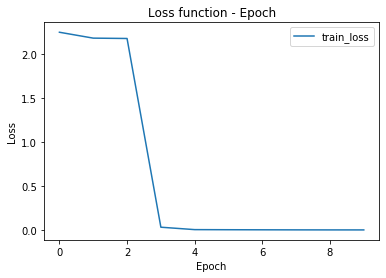

In [55]:
loss_function_epoch = DNN.L_list
#loss_function_epoch_val = DNN.L_list_val
plt.title('Loss function - Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss_function_epoch, label='train_loss')#, color='b'
#plt.plot(loss_function_epoch_val, label='val_loss')# color='b'
plt.legend(loc='best')

以上